# Importing Packages

In [48]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report

The Function dataset() standardises the diffrent readings with respect to its sample rate and makes them each reading in 1 sec time frame, we are taking mean to convert them into 1 entry

In [3]:
def dataset(df,tag,):
    final_df = pd.DataFrame()
    for i in df.columns:
        W_list = df[i]
        timestamp = datetime.datetime.fromtimestamp( W_list[0]).strftime('%Y-%m-%d %H:%M:%S')
        timestamp = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        freq = W_list[1]
        freq = int(freq)
        W_list = W_list[2:]
        ts = list(range(len(W_list)+int(freq)))        
        for j in range(0,len(W_list),int(freq)):
            ts[j:int(j+freq)] = [timestamp]*int(freq)
            timestamp = timestamp + datetime.timedelta(seconds=1)
        ts = ts[0:len(W_list)]   
        final_df[tag + str(i)] = pd.Series(W_list)
        #print(len(final_df))
        final_df["Timestamp"] = ts
    final_df = final_df.groupby(['Timestamp']).mean()
    return final_df 

# Reading Data

Using Glob package we are walking through the folders to get the data and compile them into a list of dataframes with respect to each participants

In [4]:
finaldf = pd.DataFrame() 
dflist = []
c = 1       
for name in glob.glob(r'E:/New folder/Data Science Assignement/Stress-Predict-Dataset-main/Raw_data/*'):
    finaldflist = []
    filenames = glob.glob(name+'/*.csv')

    for csv in filenames:
        if 'tag' in csv or 'IBI' in csv or "ACC" in csv:
            continue
        else:
            df = pd.read_csv(csv,header= None)
            tag = csv.split("\\")
            tag = tag[-1].replace('.csv','')
            x =dataset(df,tag)
            finaldflist.append(x)
    finaldf_each = pd.DataFrame()
    finaldf_each['Timestamp'] = 1
    for i in finaldflist:
        finaldf_each = finaldf_each.merge(i, how = 'outer', on = 'Timestamp')
    finaldf_each = finaldf_each.dropna(axis = 0 )
    finaldf_each["Participant"] = c
    c += 1   
    dflist.append(finaldf_each)

# Adding labels and Data Cleaning

Now we add the Tag df to determine the stress level <br>
Stress = 1 = Stressful <br>
Stress = 0 = Not stressful <br>
Stress = -1 = Base reading

In [5]:
def timeconvert(a):
    return datetime.datetime.strptime(datetime.datetime.fromtimestamp(a).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')

In [6]:
file = []
for name in glob.glob(r'E:/New folder/Data Science Assignement/Stress-Predict-Dataset-main/Raw_data/*/tag*.csv'):
    df = pd.read_csv(name,header= None)
    df[0] = df[0].apply(timeconvert)
    ## correction of Tag for S10 and S30
    if "S18" in name or "S30" in name:
        df[0][0] = df[0][0] + + datetime.timedelta(hours=12)
    file.append(df)

Note there is an error in data of tags for subject 18 and 30 the first tag is 12 hours behind,

In [7]:
for i in range(len(dflist)): 
    dflist[i]['Y'] = 0
    cond0 = [dflist[i]["Timestamp"]<file[i][0][0]]
    choice0 = [-1]
    dflist[i]['Y'] = np.select(cond0,choice0,default = dflist[i]['Y'])
    for j in range(0,6):
        if j%2 == 0:
            cond = [np.logical_and(dflist[i]["Timestamp"]>file[i][0][j],dflist[i]["Timestamp"]<file[i][0][j+1])]
            choice = [1]
            dflist[i]['Y'] = np.select(cond,choice,default = dflist[i]['Y'])
        elif j == 7:
            cond2 = [dflist[i]["Timestamp"]>file[i][0][j]]
            choice2 = [2]
            dflist[i]['Y'] = np.select(cond2,choice2,default = dflist[i]['Y'])
    dflist[i] = dflist[i][dflist[i]["Y"] != 2 ]

In [8]:
dflist[10].describe()

BVP0         EDA0          HR0        TEMP0  Participant  \
count  3268.000000  3268.000000  3268.000000  3268.000000       3268.0   
mean      0.000680     0.346763    89.024697    27.544002         11.0   
std      10.510241     0.159075     8.286253     0.321649          0.0   
min    -119.763281     0.139016    52.000000    26.970000         11.0   
25%      -2.183008     0.238953    84.700000    27.270000         11.0   
50%       0.059375     0.285079    89.040000    27.510000         11.0   
75%       2.489023     0.413992    94.050000    27.890000         11.0   
max      87.644219     1.592250   112.580000    28.110000         11.0   

                 Y  
count  3268.000000  
mean      0.170747  
std       0.723205  
min      -1.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

now we create a base reading under normal condition <br>
this is to unify the data of diffrent subjects as base reading of 1 person can very from base rerading of the other person

In [9]:
df_base = []
for i in dflist:
    basedf = i[i["Y"] == -1]
    df_base.append(basedf)
df_base[0].head()
    
df_base[17].describe()

BVP0        EDA0         HR0       TEMP0  Participant      Y
count  669.000000  669.000000  669.000000  669.000000        669.0  669.0
mean    -0.013734    1.603236   78.243886   27.614634         18.0   -1.0
std     14.321722    0.728761    7.853514    0.801909          0.0    0.0
min    -95.053125    0.555961   58.000000   26.750000         18.0   -1.0
25%     -1.984063    0.730915   73.100000   26.830000         18.0   -1.0
50%     -0.037031    1.684932   78.450000   27.290000         18.0   -1.0
75%      1.977812    2.249728   84.950000   28.470000         18.0   -1.0
max    126.206094    2.937746   92.450000   29.090000         18.0   -1.0

In [10]:
for i in range(len(dflist)):
    dflist[i] = dflist[i][dflist[i]["Y"] != -1]

In [11]:
dflist[10].describe()

BVP0         EDA0          HR0        TEMP0  Participant  \
count  2645.000000  2645.000000  2645.000000  2645.000000       2645.0   
mean     -0.000178     0.377488    90.103626    27.458771         11.0   
std      10.368740     0.161945     7.701651     0.277576          0.0   
min    -119.763281     0.196673    71.050000    26.970000         11.0   
25%      -2.169219     0.265860    84.970000    27.230000         11.0   
50%       0.076406     0.299173    89.720000    27.450000         11.0   
75%       2.456250     0.481058    95.020000    27.610000         11.0   
max      68.191406     1.592250   112.580000    28.050000         11.0   

                 Y  
count  2645.000000  
mean      0.446503  
std       0.497224  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

Now lets plot the time- graphs for first data subject

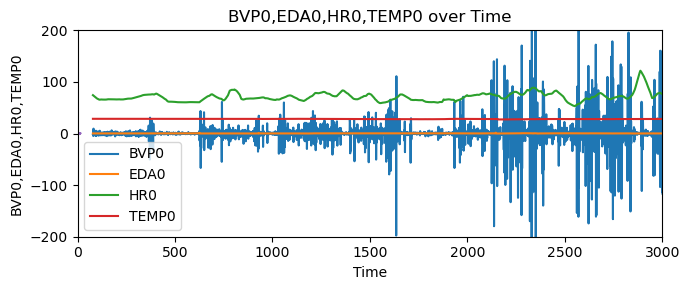

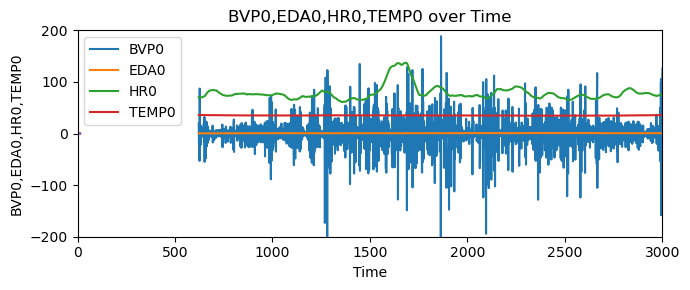

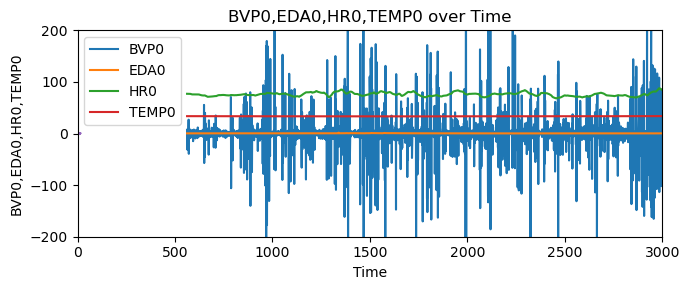

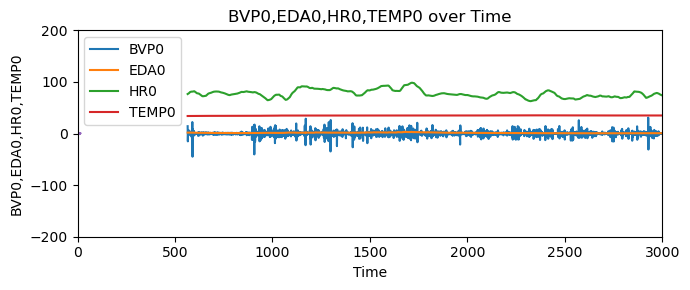

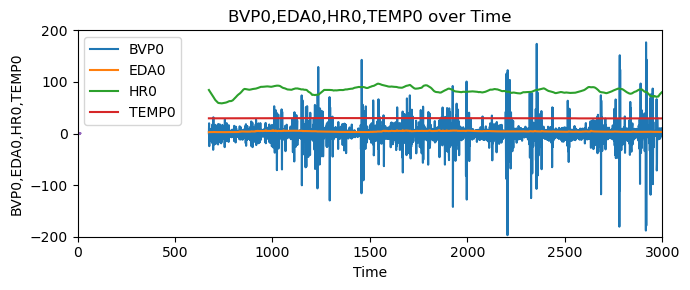

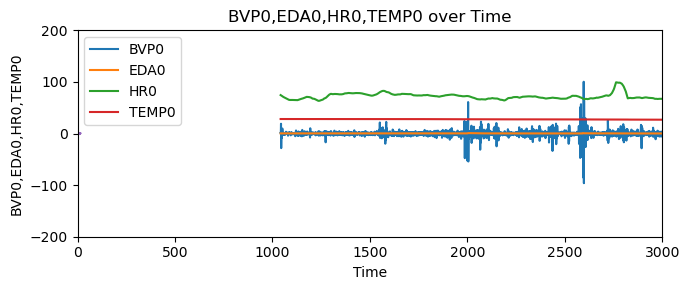

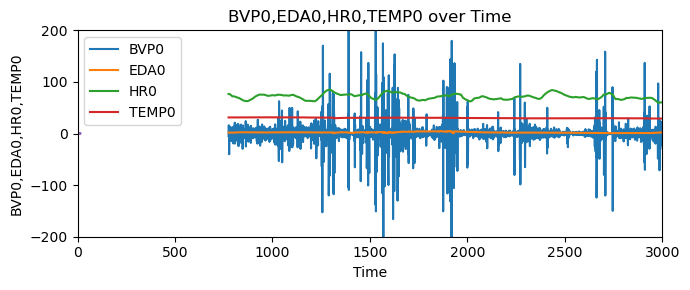

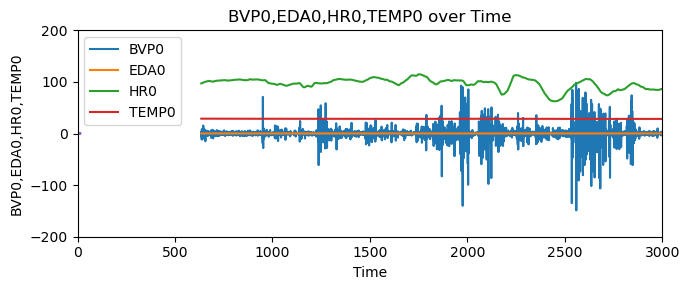

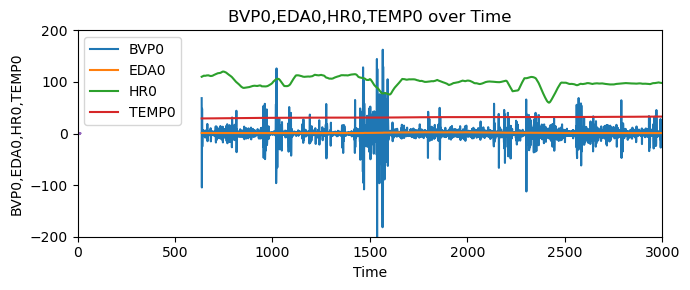

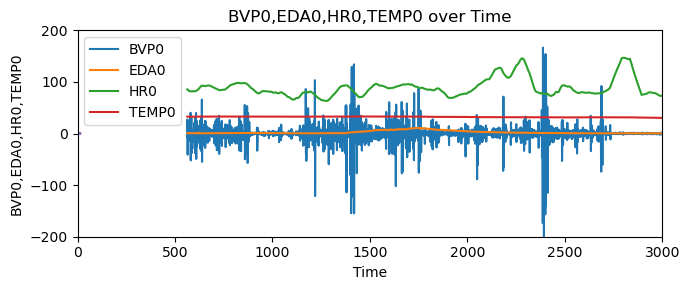

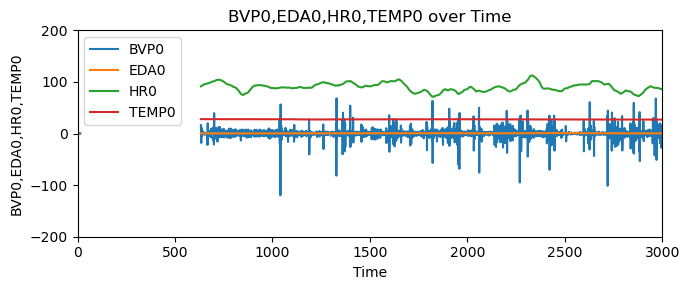

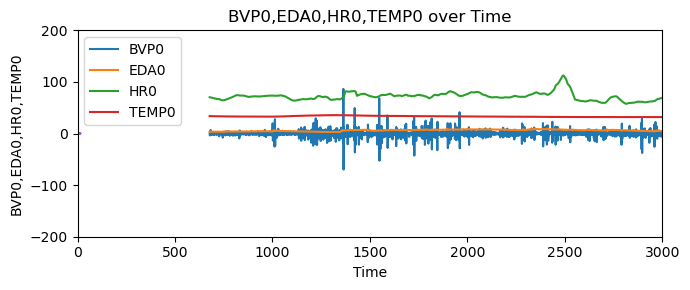

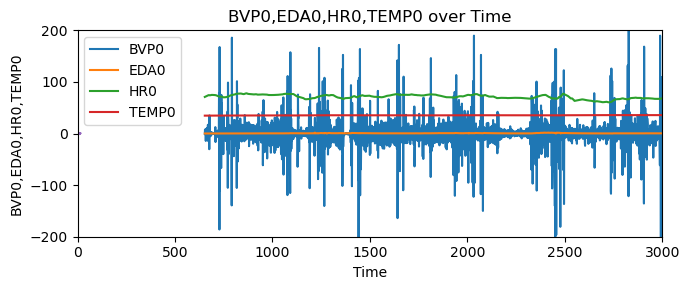

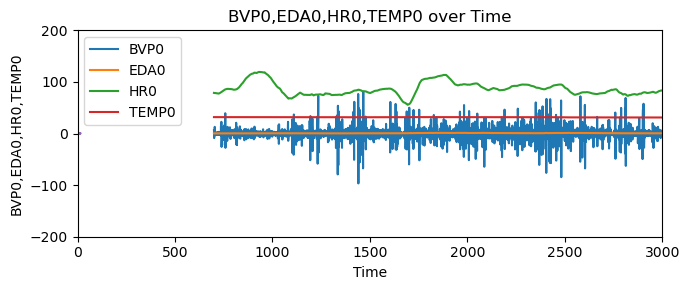

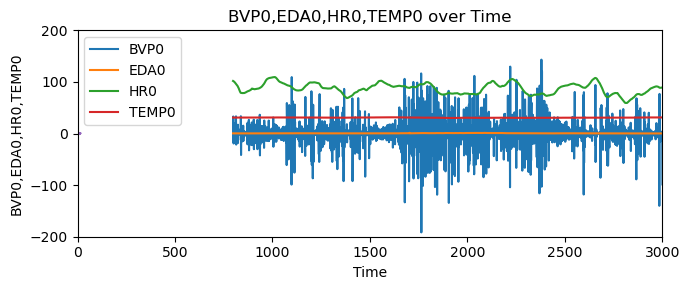

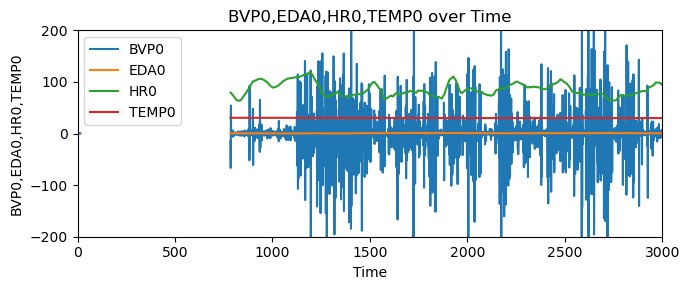

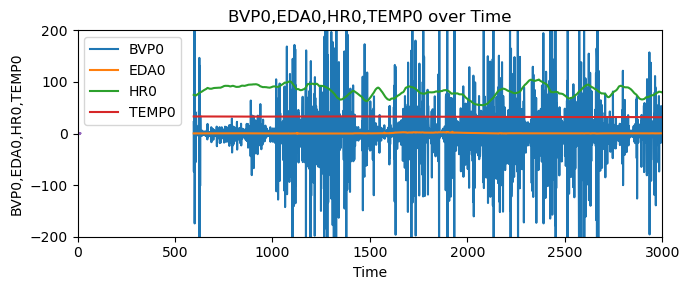

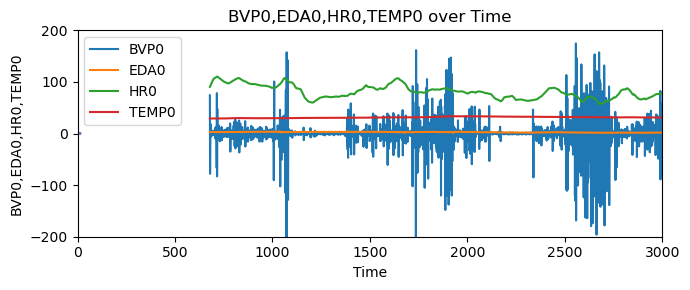

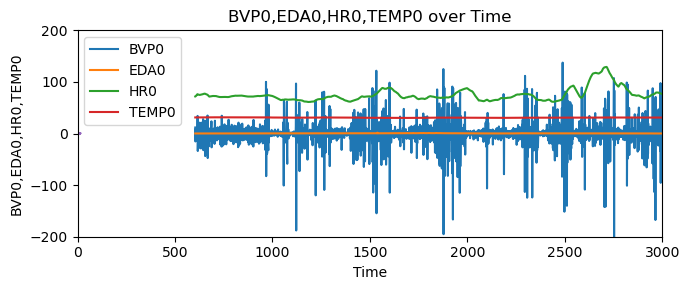

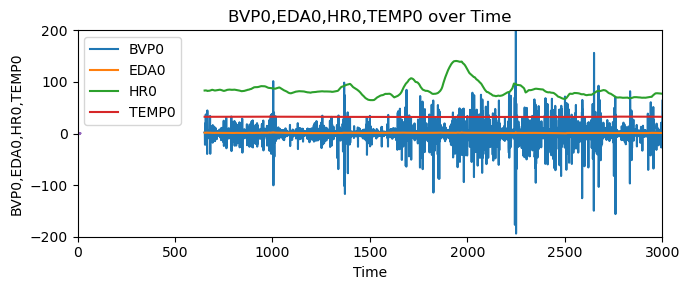

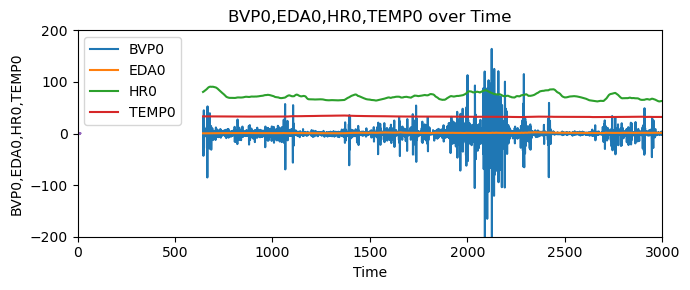

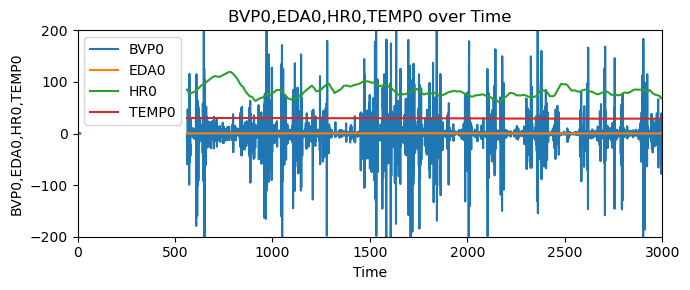

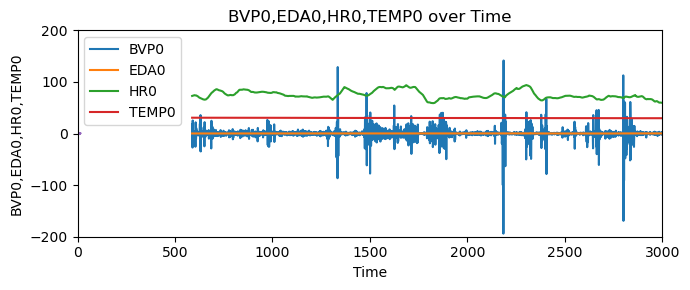

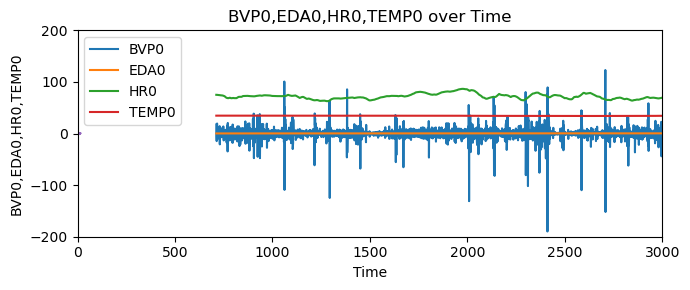

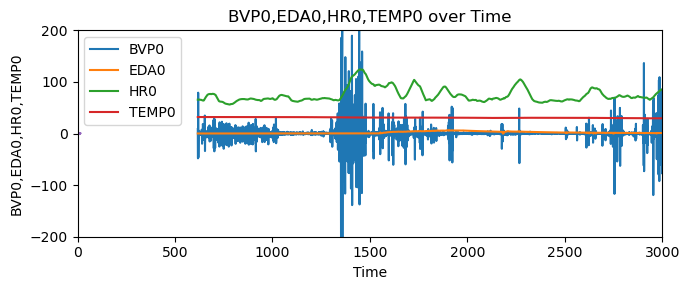

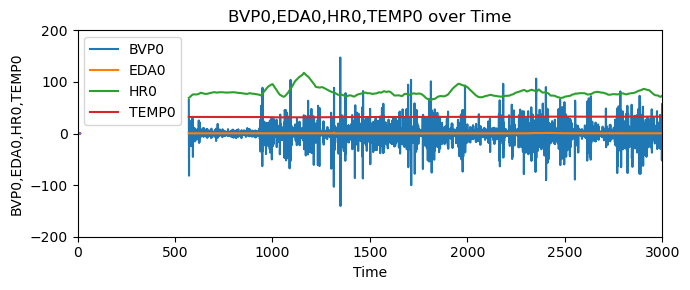

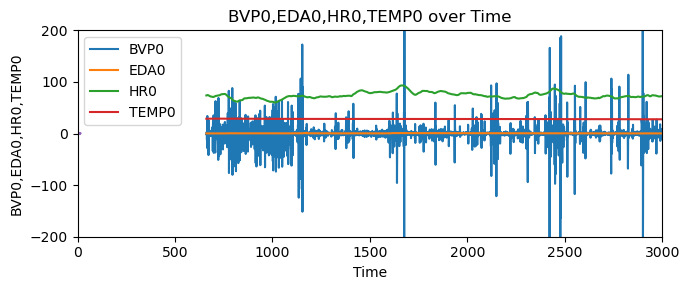

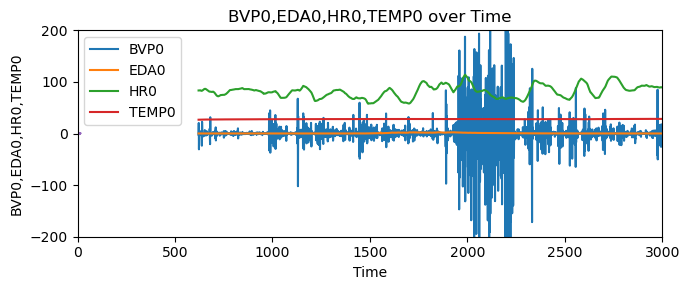

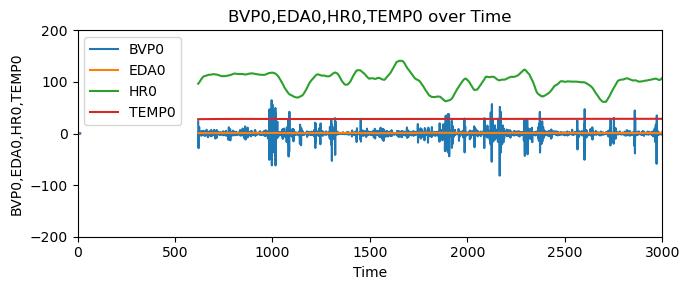

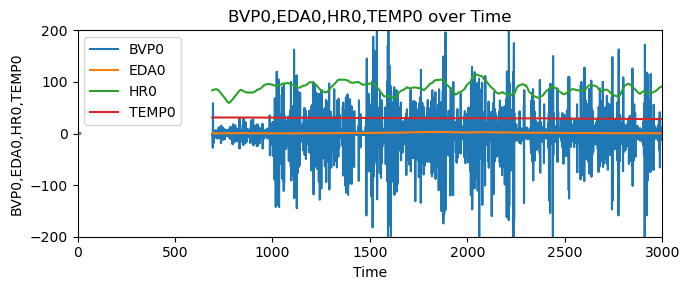

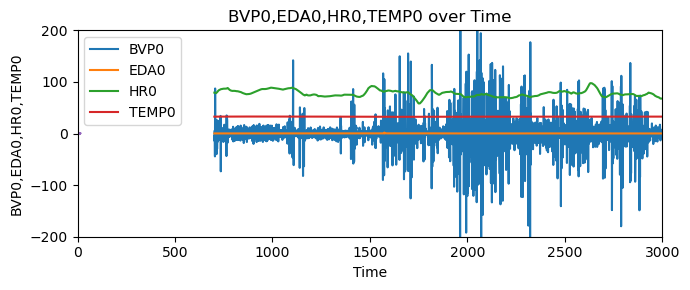

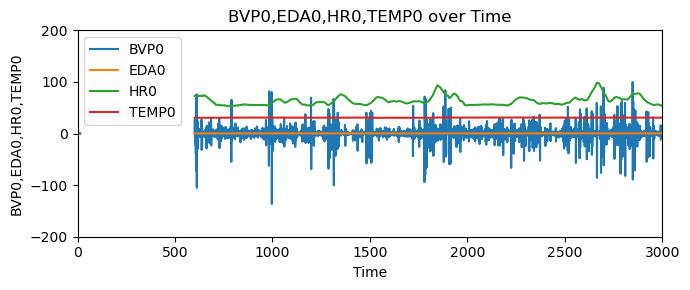

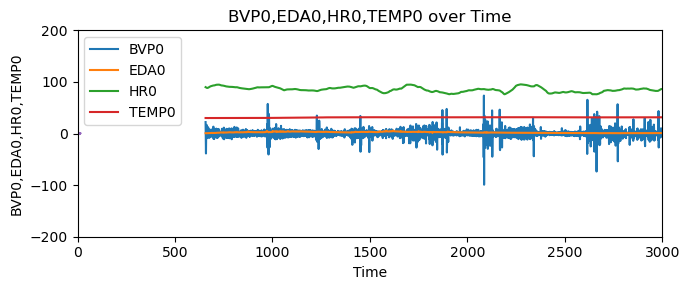

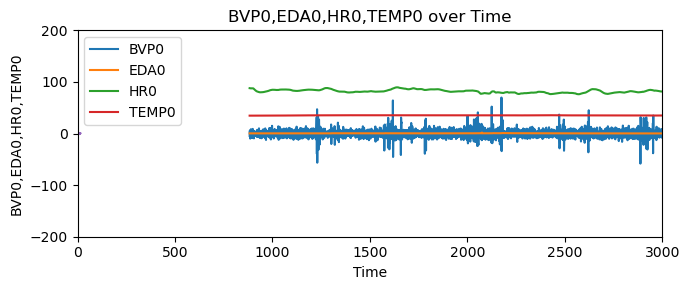

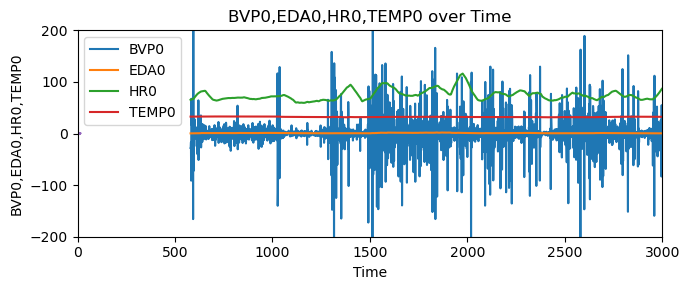

In [22]:
for j in dflist:
    fig, ax = plt.subplots()
    cols_to_plot = ["BVP0","EDA0","HR0","TEMP0"]
    j[cols_to_plot].plot(ax=ax)

    plt.rcParams["figure.figsize"] = [7, 3]
    plt.rcParams["figure.autolayout"] = True

    x = np.linspace(-15, 15, 100)
    y = np.sin(x)

    plt.plot(x, y)

    plt.xlim(0, 3000)
    plt.ylim(-200, 200)

    # Add a title and labels to the x and y axes
    plt.title('BVP0,EDA0,HR0,TEMP0 over Time')
    plt.xlabel('Time')
    plt.ylabel('BVP0,EDA0,HR0,TEMP0')
    # Show the plot
    plt.show()   

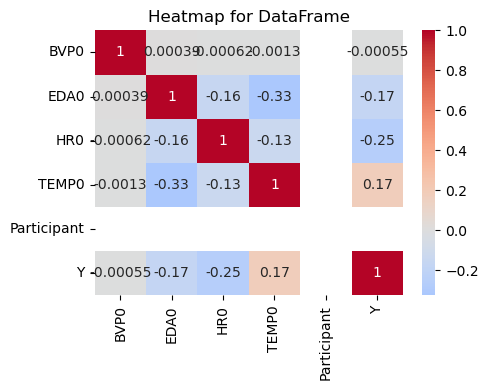

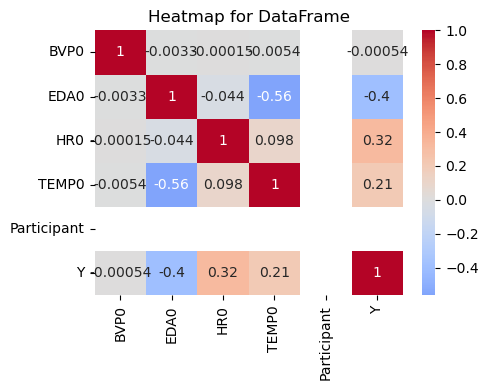

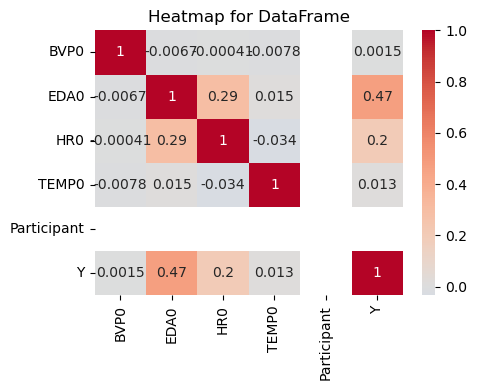

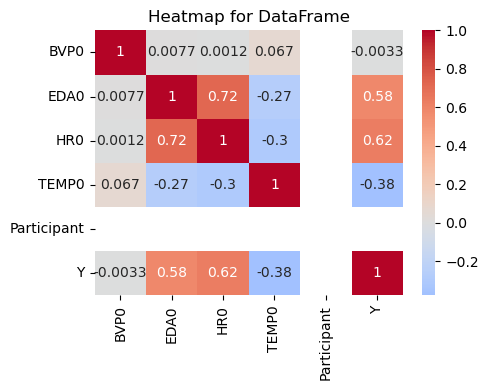

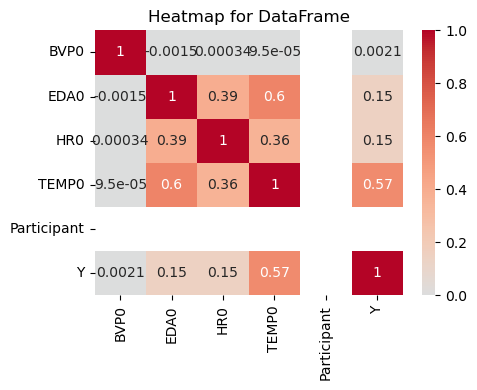

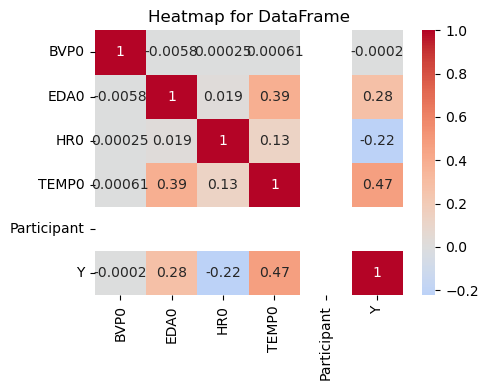

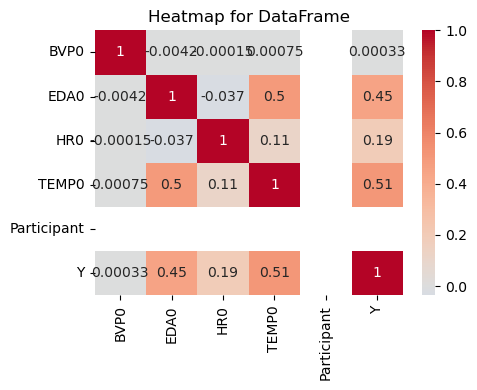

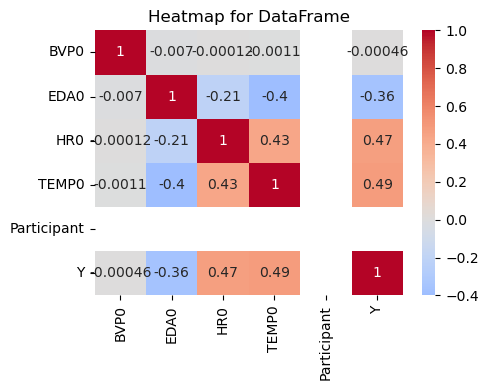

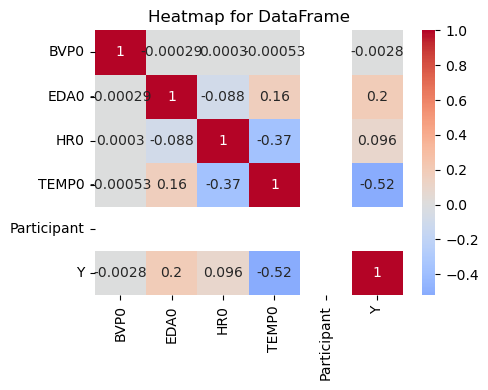

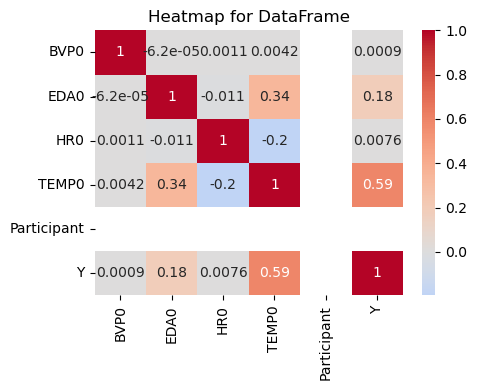

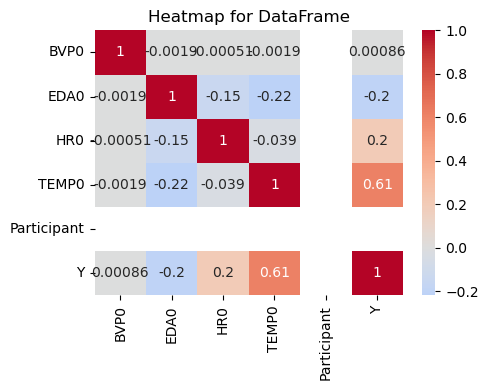

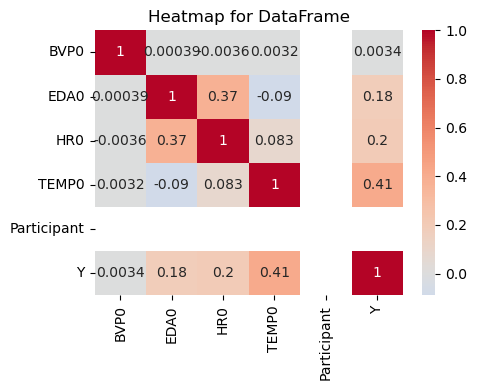

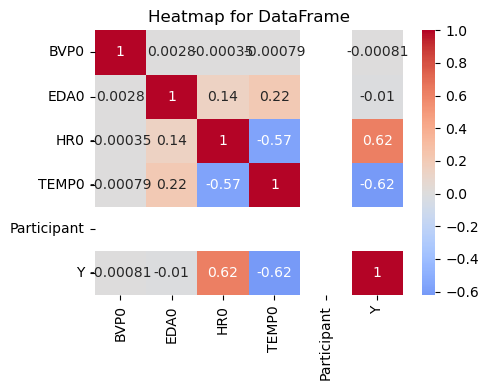

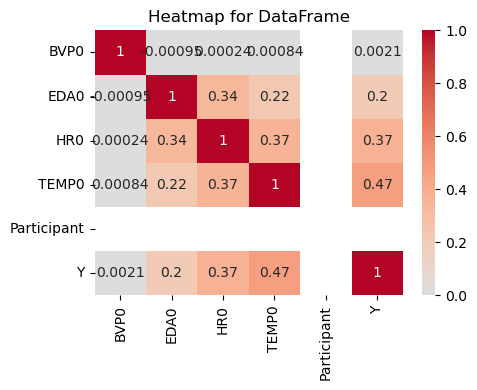

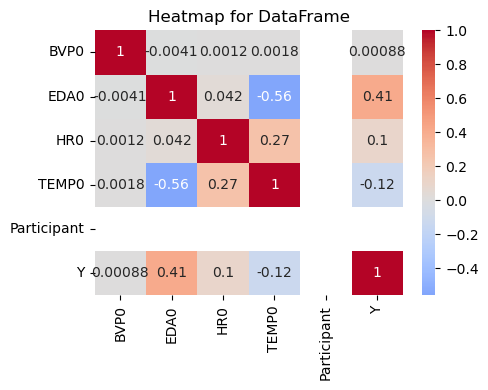

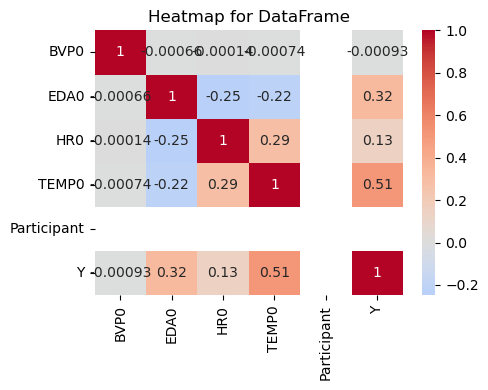

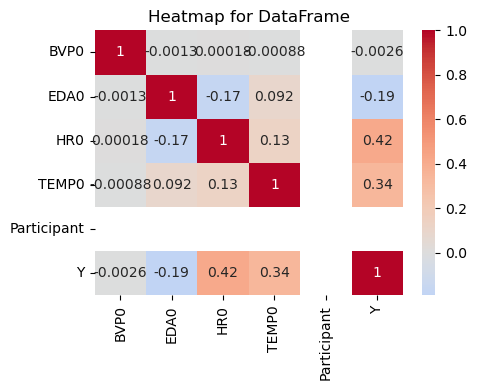

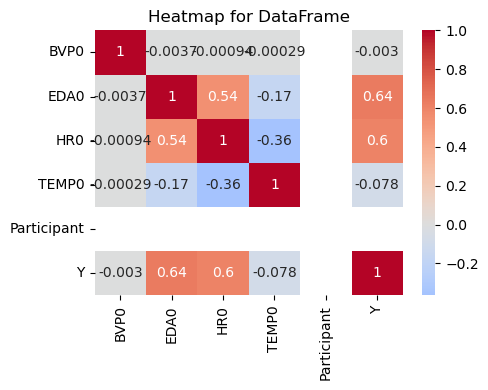

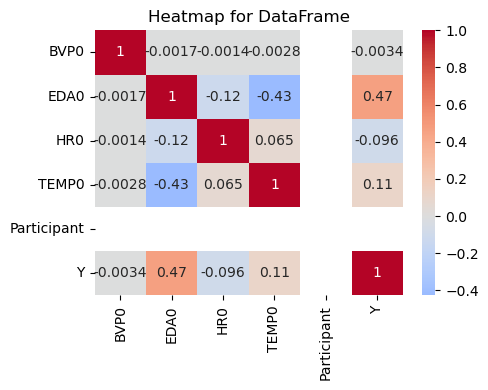

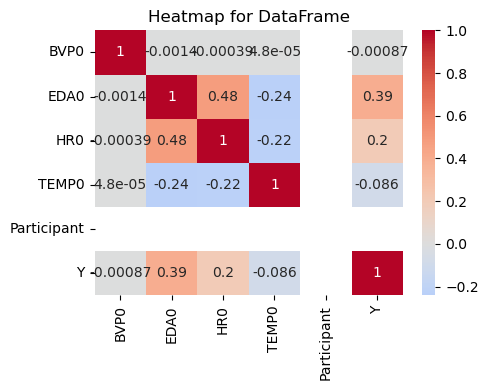

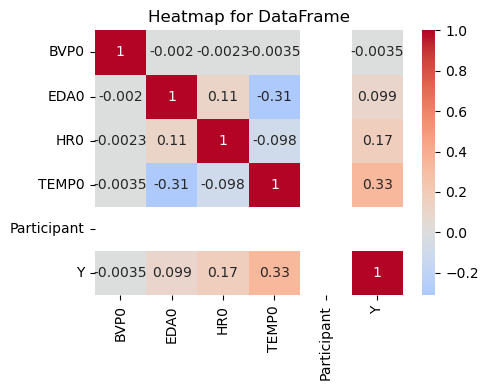

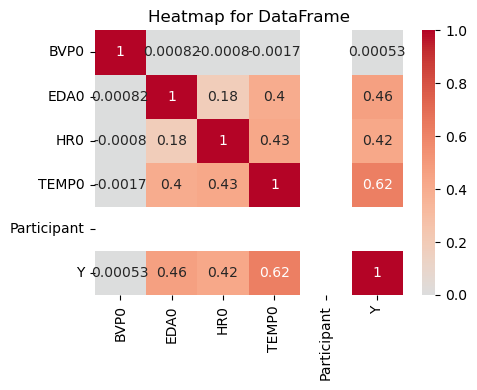

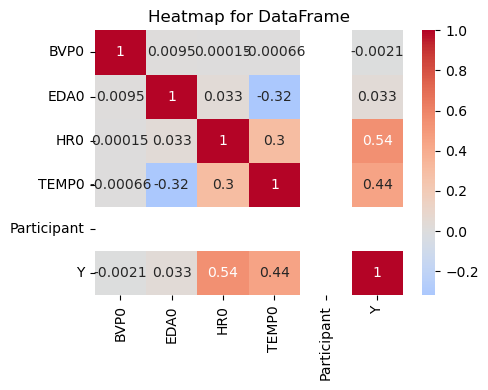

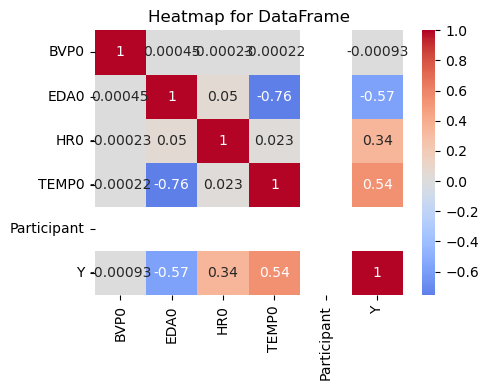

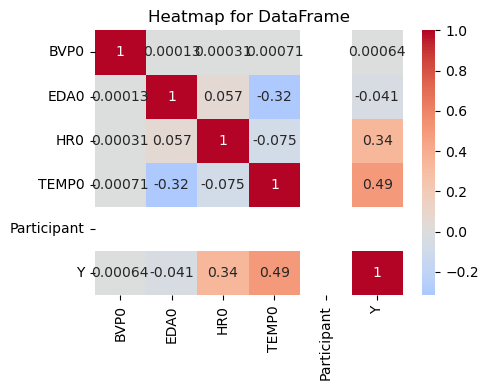

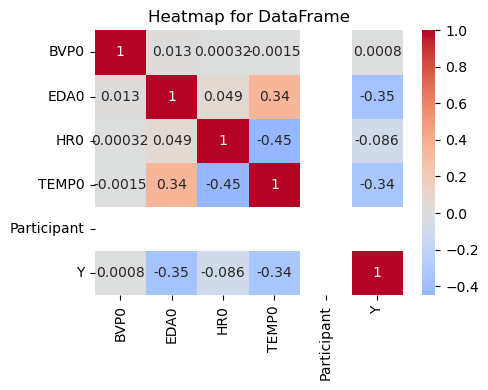

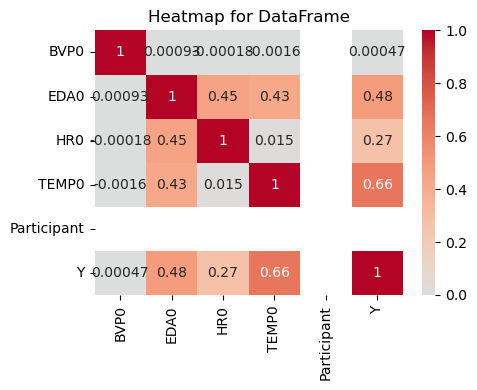

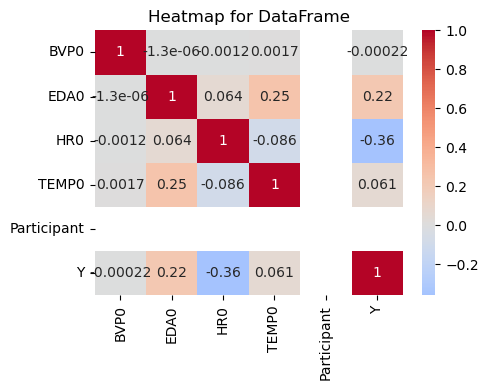

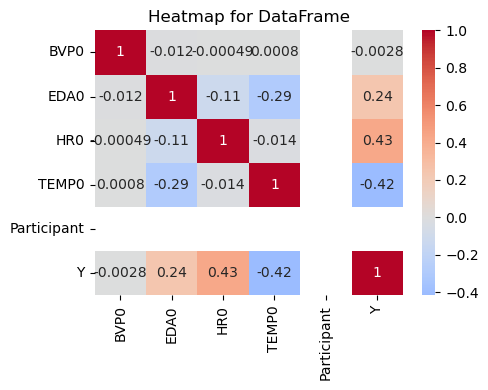

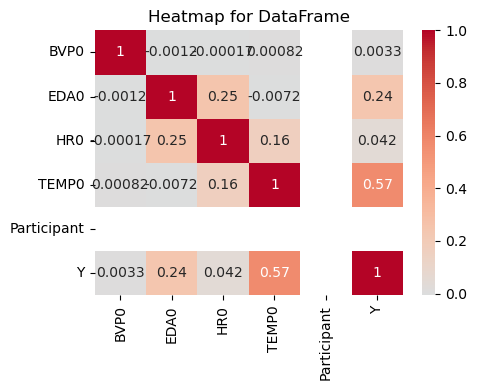

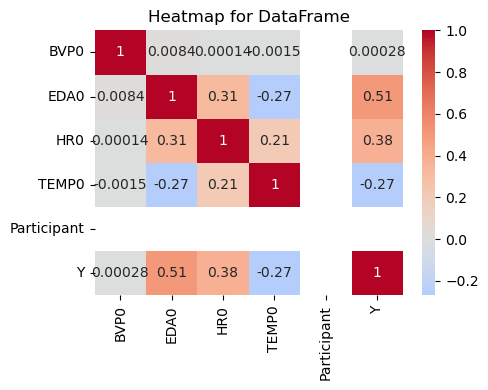

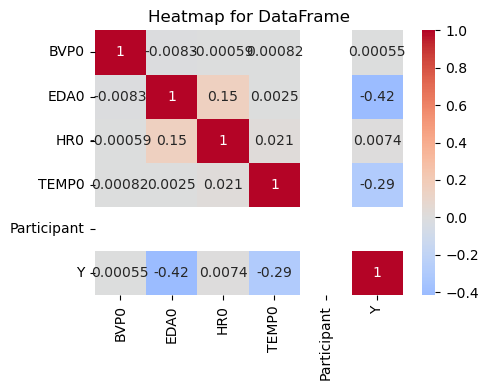

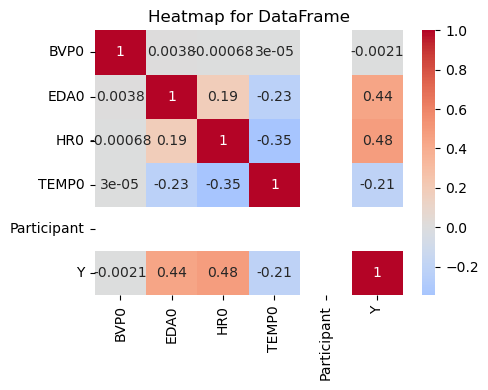

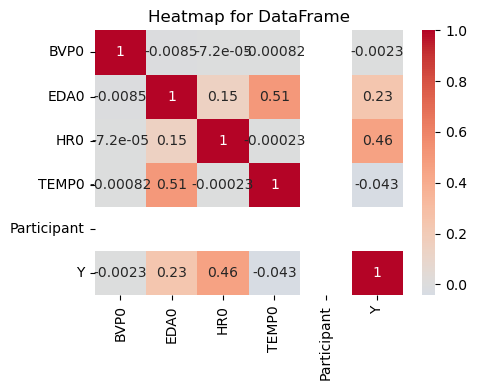

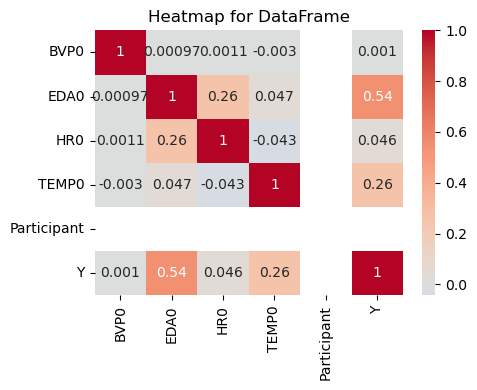

In [26]:
for i in dflist:
    plt.figure(figsize=(5, 4))
    plt.title("Heatmap for DataFrame")
    sns.heatmap(i.corr(), annot=True, cmap='coolwarm', center=0)
    plt.show()


the above graph shows a positive co-relation for EDA and HR with respect to the outcome.

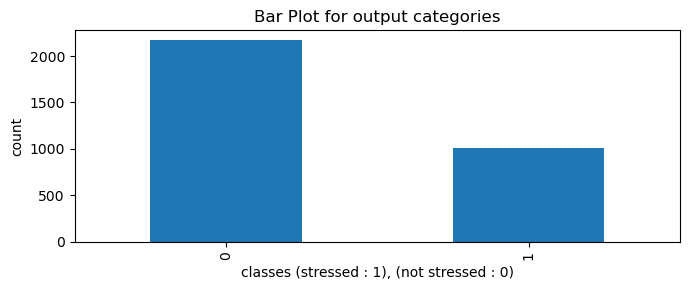

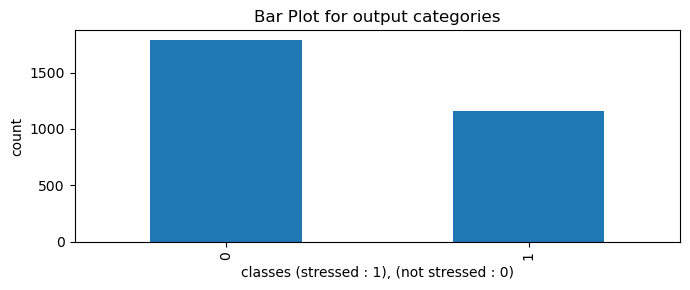

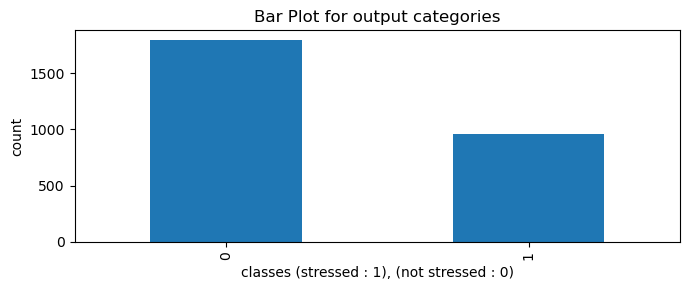

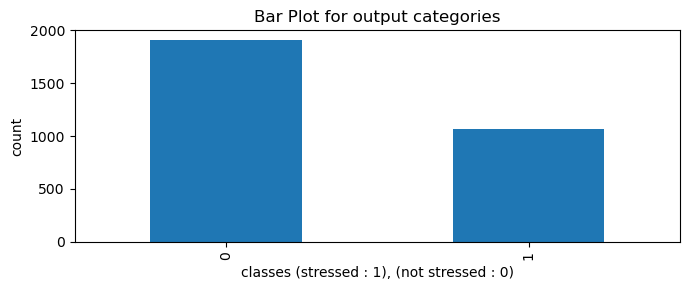

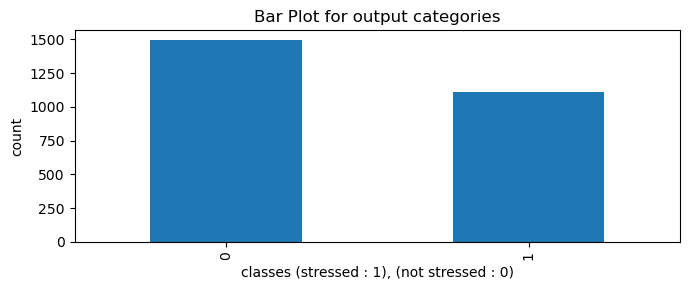

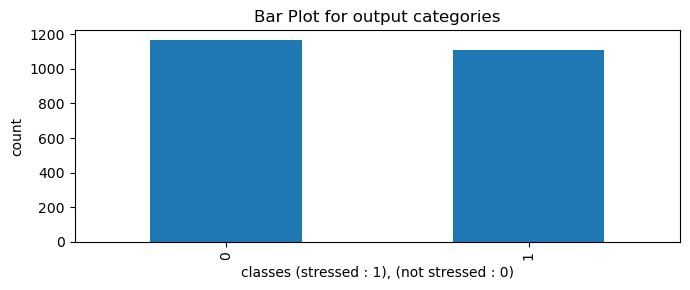

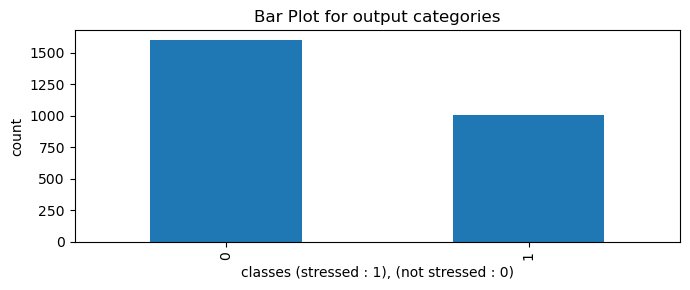

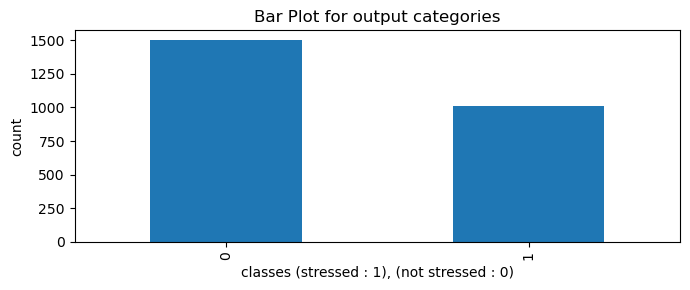

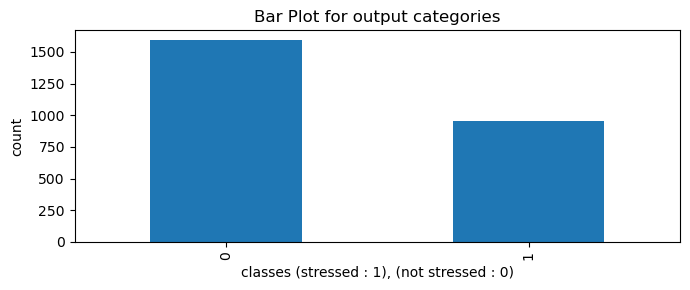

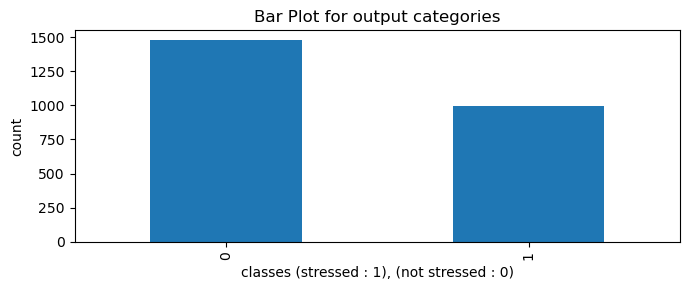

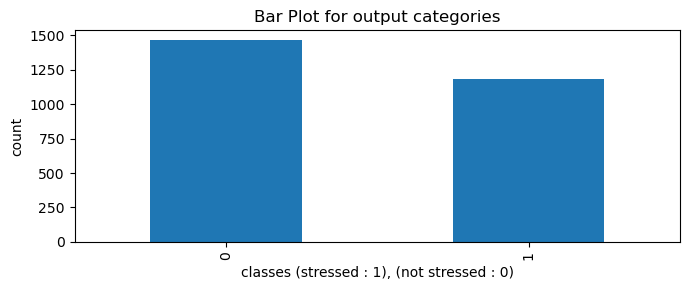

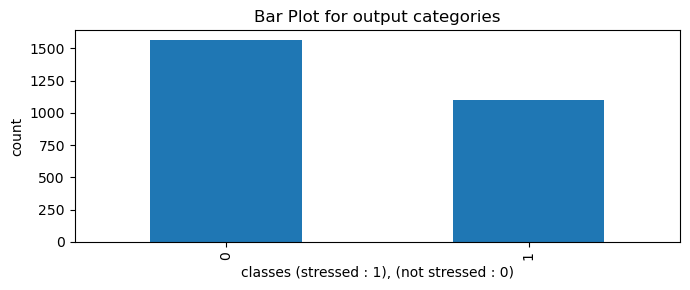

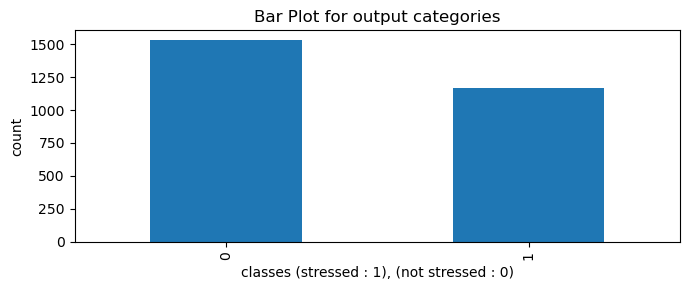

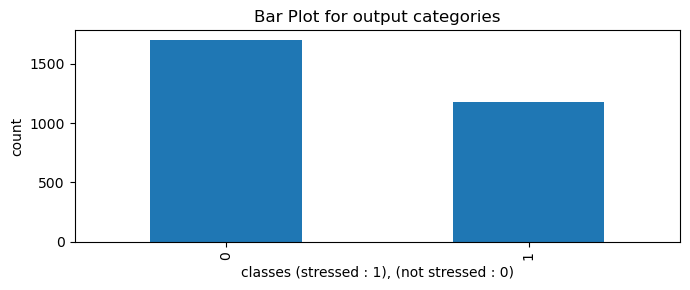

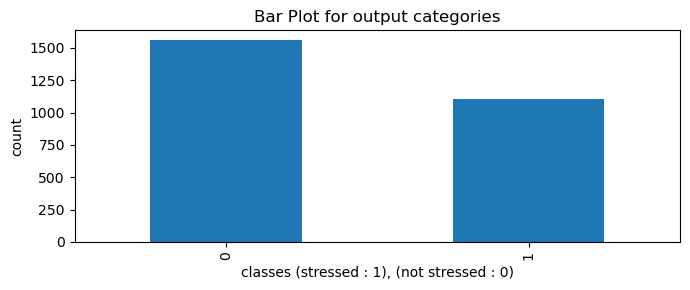

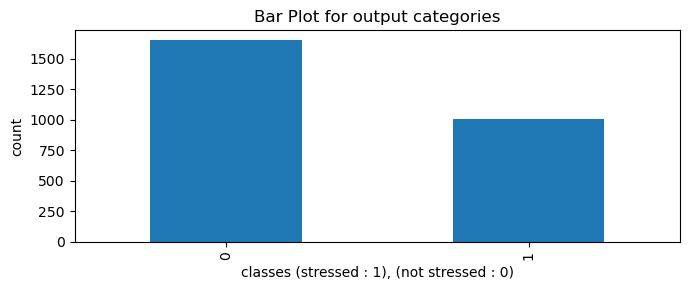

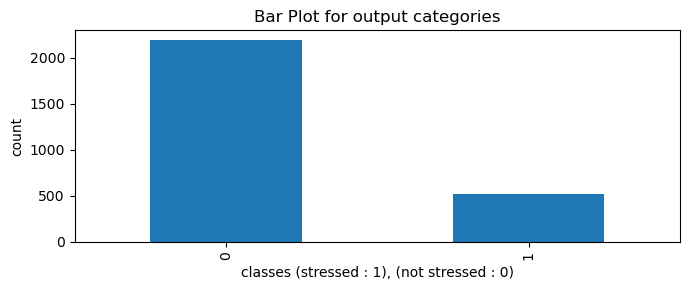

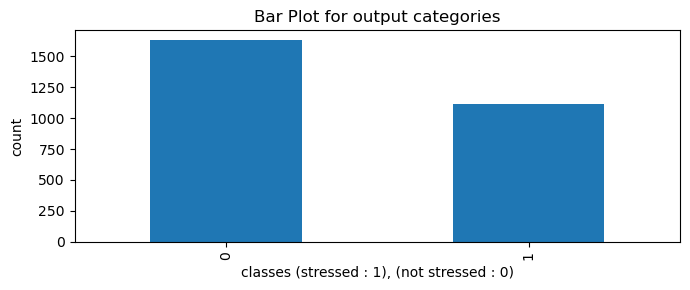

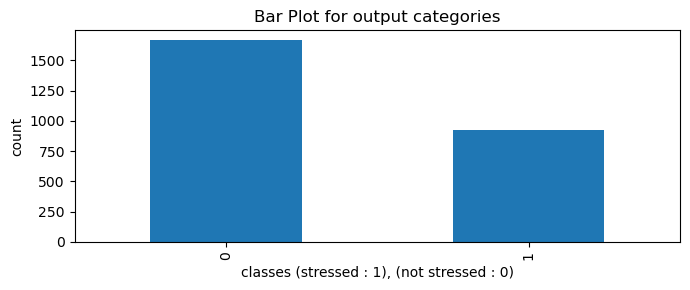

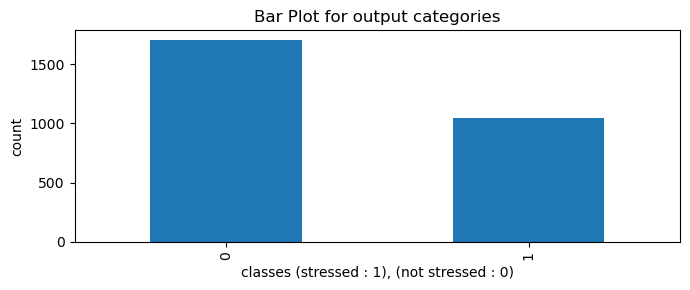

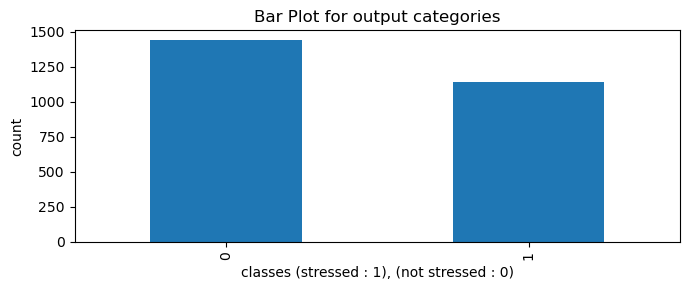

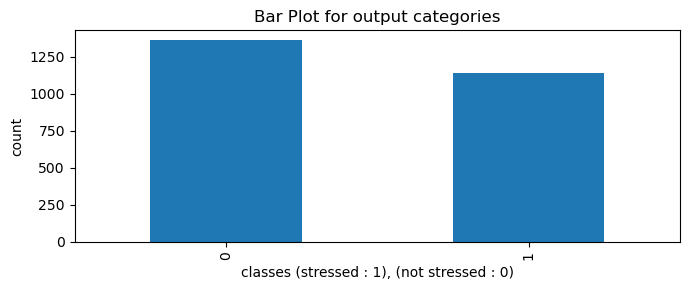

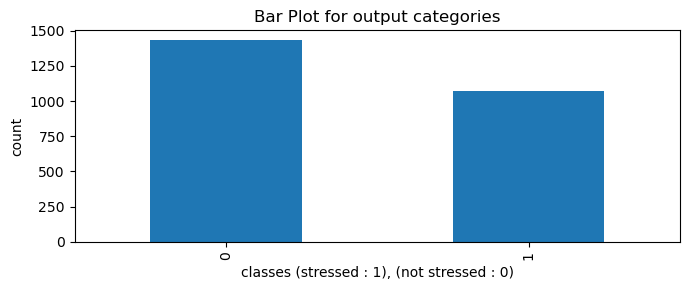

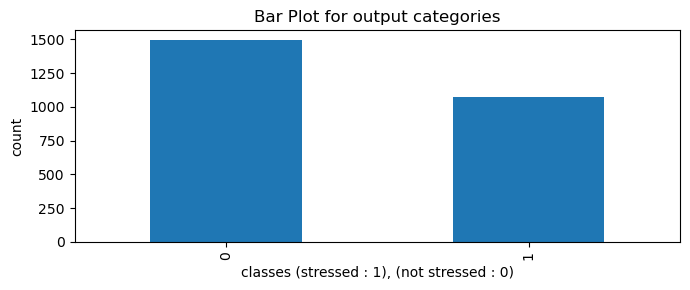

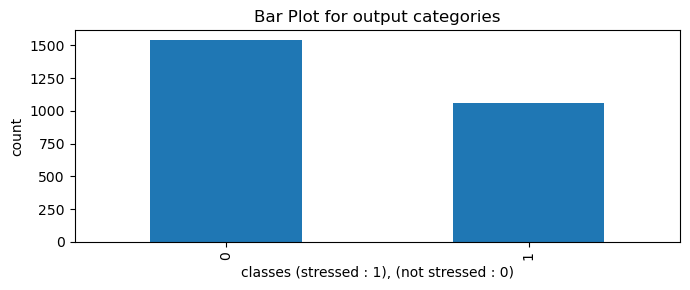

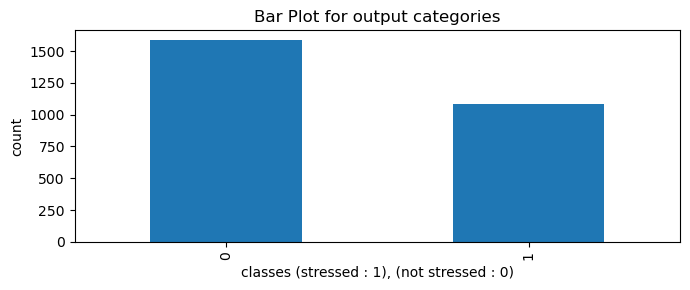

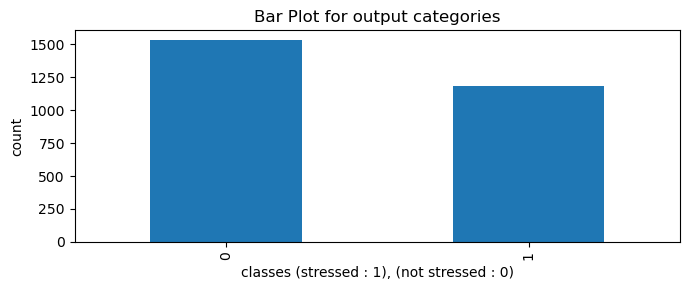

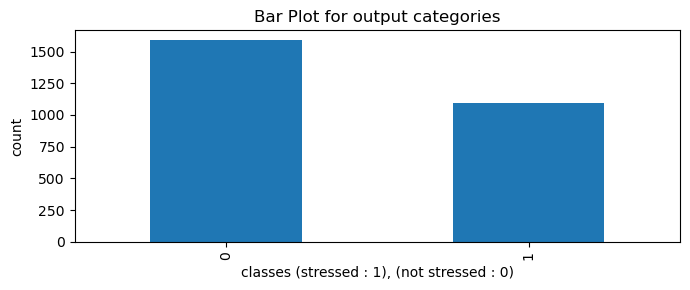

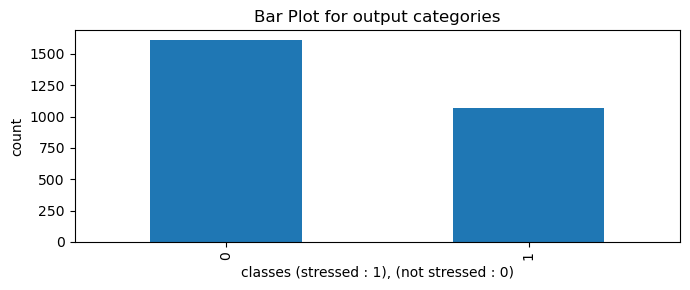

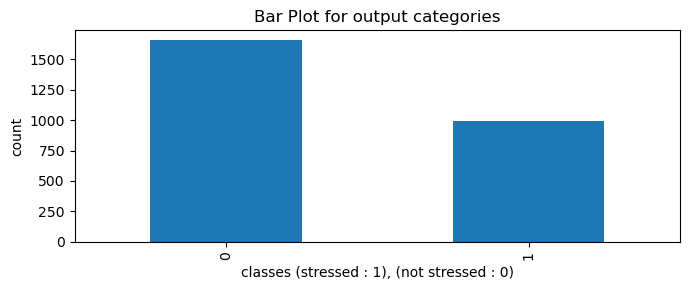

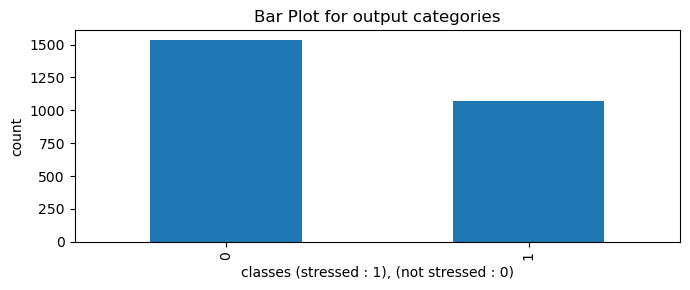

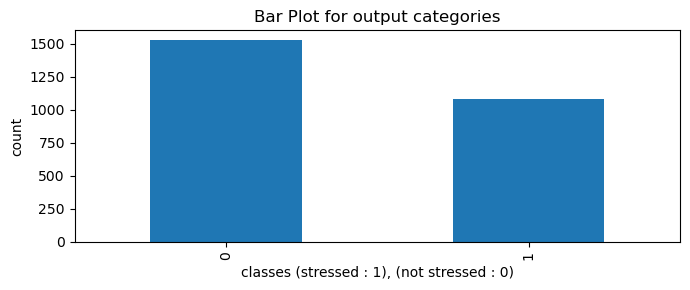

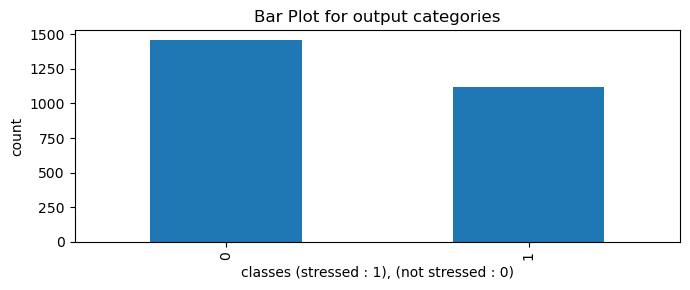

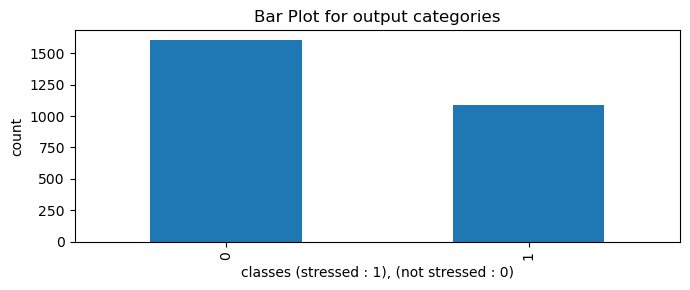

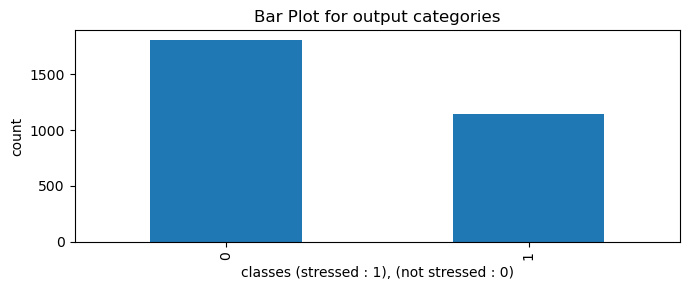

In [53]:
for i in dflist:
    x= i['Y'].value_counts()
    x.plot(kind='bar')

    # Add labels and title
    plt.xlabel('classes (stressed : 1), (not stressed : 0)')
    plt.ylabel('count')
    plt.title('Bar Plot for output categories')

    # Display the plot
    plt.show()

# Modeling

we check for autocorrelation between observations
    

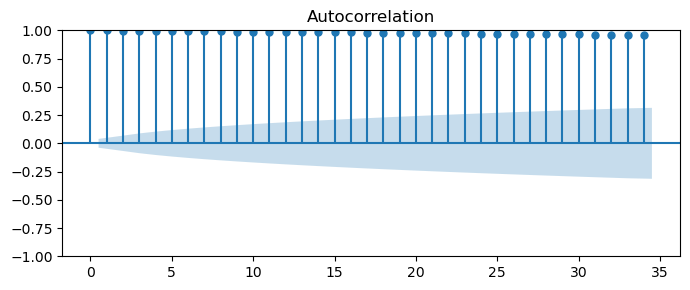

Timestamp


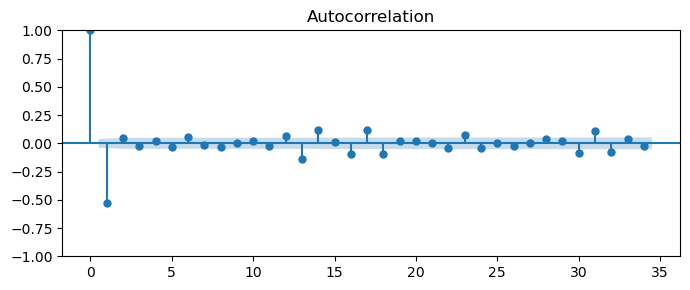

BVP0


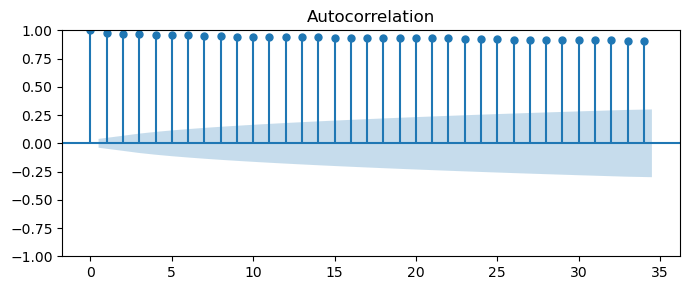

EDA0


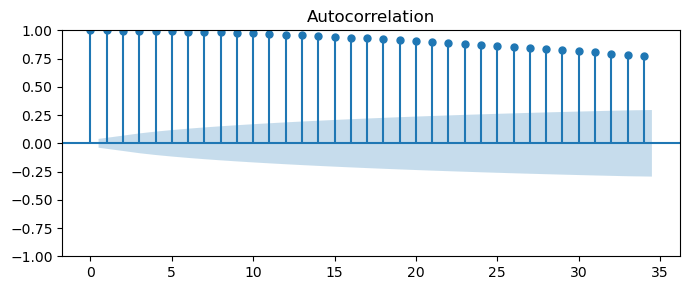

HR0


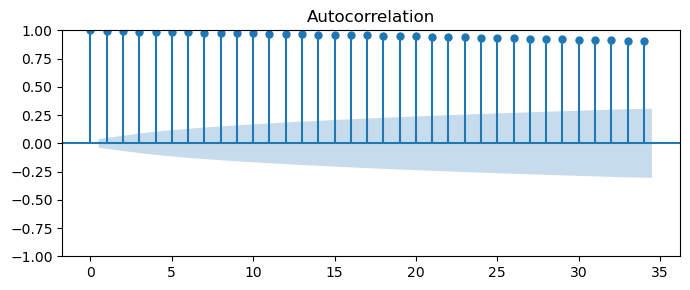

TEMP0


C:\Users\Akshay D Nair\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


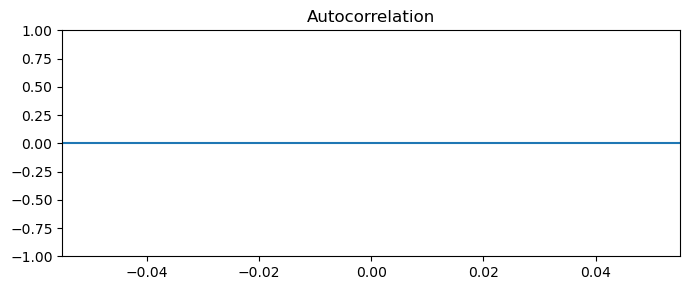

Participant


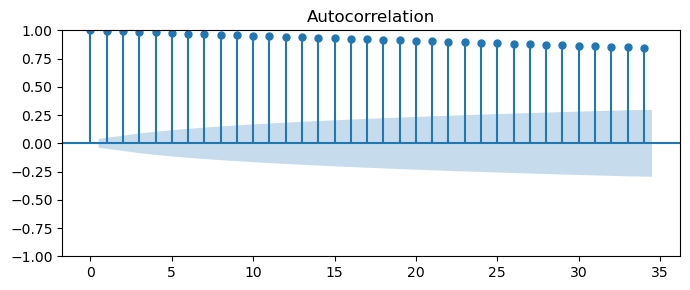

Y


In [27]:
# Plot ACF
for i in dflist[7].columns:   
    plot_acf(dflist[7][i])
    plt.show()
    print(i)

The above graph shows that there is high auto-correlation for each features

In [28]:
import time
def epochconvert(a):
    a = time.strptime(a, '%Y-%m-%d %H:%M:%S')
    u = int(time.mktime(a))
    return u
for i in range(len(dflist)):
    dflist[i]['Timestamp'] = dflist[i]['Timestamp'].astype(str).apply(epochconvert)

first we devide the data in train and test. For our case we are splitting the data in 60-40 train-test split. As the data we have here is a time series we are gonna split sequencially and not random. then we are applying random forest calassifier

In [42]:
dfreport =[]
dfcm = []
dfacc = []
dfrecall = []
dff1 = []
for df in dflist:
    X = df.drop(['Participant','Y','Timestamp',], axis=1)
    y = df["Y"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,shuffle=False)
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the scaler on your training data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    # Fit the model on the training data
    rfc.fit(X_train_scaled, y_train)

    # Predict on the testing data
    y_pred = rfc.predict(X_test_scaled)

    # Generate a classification report
    report = classification_report(y_test, y_pred)
    dfreport.append(report)
    cm = confusion_matrix(y_test, y_pred)
    dfcm.append(cm)
    acc = accuracy_score(y_test, y_pred)
    dfacc.append(acc)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    dfrecall.append(recall)
    dff1.append(f1)

C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\skle

In [52]:
for i in range(len(dflist)):
    print(f"for subject {i}'s model'")
#    print(f'accuracy = {dfacc[i]}')
#    print(f'Confusion matrix = {dfcm[i]}')
#    print(f'recall = {dfrecall[i]}')
#    print(f'F1 Score = {dff1[i]}')
    print('model report', dfreport[i])

for subject 0's model'
model report               precision    recall  f1-score   support

           0       1.00      0.58      0.73      1272
           1       0.00      0.00      0.00         0

    accuracy                           0.58      1272
   macro avg       0.50      0.29      0.37      1272
weighted avg       1.00      0.58      0.73      1272

for subject 1's model'
model report               precision    recall  f1-score   support

           0       1.00      0.27      0.43      1178
           1       0.00      0.00      0.00         0

    accuracy                           0.27      1178
   macro avg       0.50      0.14      0.21      1178
weighted avg       1.00      0.27      0.43      1178

for subject 2's model'
model report               precision    recall  f1-score   support

           0       1.00      0.51      0.67      1102
           1       0.00      0.00      0.00         0

    accuracy                           0.51      1102
   macro avg       0

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
classification_reports = []
for df in dflist:
    X = df.drop(['Participant','Y','Timestamp',], axis=1)
    y = df["Y"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,shuffle=False)
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create a dense neural network model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile and train the model

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    classification_rep = classification_report(y_test, y_pred_classes)
    classification_reports.append(classification_rep)
    print("Classification Report:\n", classification_rep)

40/40 [==============================] - 0s 861us/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.54      0.70      1272
           1       0.00      0.00      0.00         0

    accuracy                           0.54      1272
   macro avg       0.50      0.27      0.35      1272
weighted avg       1.00      0.54      0.70      1272

37/37 [==============================] - 0s 1ms/step
Classification Report:


C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\skle

               precision    recall  f1-score   support

           0       1.00      0.37      0.54      1178
           1       0.00      0.00      0.00         0

    accuracy                           0.37      1178
   macro avg       0.50      0.18      0.27      1178
weighted avg       1.00      0.37      0.54      1178

35/35 [==============================] - 0s 915us/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89      1102
           1       0.00      0.00      0.00         0

    accuracy                           0.81      1102
   macro avg       0.50      0.40      0.45      1102
weighted avg       1.00      0.81      0.89      1102

38/38 [==============================] - 0s 918us/step


C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.23      0.38      1190
           1       0.00      0.00      0.00         0

    accuracy                           0.23      1190
   macro avg       0.50      0.12      0.19      1190
weighted avg       1.00      0.23      0.38      1190

33/33 [==============================] - 0s 970us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       953
           1       0.34      0.95      0.50        88

    accuracy                           0.84      1041
   macro avg       0.67      0.89      0.70      1041
weighted avg       0.94      0.84      0.87      1041



C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


29/29 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.06      0.11       626
           1       0.32      1.00      0.49       284

    accuracy                           0.35       910
   macro avg       0.66      0.53      0.30       910
weighted avg       0.79      0.35      0.23       910

33/33 [==============================] - 0s 926us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97       972
           1       0.00      0.00      0.00        70

    accuracy                           0.93      1042
   macro avg       0.47      0.50      0.48      1042
weighted avg       0.87      0.93      0.90      1042

32/32 [==============================] - 0s 967us/step


C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       894
           1       0.00      0.00      0.00       109

    accuracy                           0.89      1003
   macro avg       0.45      0.50      0.47      1003
weighted avg       0.79      0.89      0.84      1003

32/32 [==============================] - 0s 1ms/step
Classification Report:


C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

           0       0.87      0.97      0.92       886
           1       0.17      0.05      0.07       133

    accuracy                           0.85      1019
   macro avg       0.52      0.51      0.49      1019
weighted avg       0.78      0.85      0.81      1019

31/31 [==============================] - 0s 963us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       858
           1       0.00      0.00      0.00       132

    accuracy                           0.87       990
   macro avg       0.43      0.50      0.46       990
weighted avg       0.75      0.87      0.80       990

34/34 [==============================] - 0s 968us/step


C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.44      0.61       906
           1       0.22      0.95      0.36       152

    accuracy                           0.52      1058
   macro avg       0.60      0.70      0.49      1058
weighted avg       0.87      0.52      0.58      1058

34/34 [==============================] - 0s 984us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.15      0.23       940
           1       0.03      0.21      0.06       126

    accuracy                           0.15      1066
   macro avg       0.31      0.18      0.15      1066
weighted avg       0.52      0.15      0.21      1066

34/34 [==============================] - 0s 969us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90       972
           1       0.17      0.19      0.18       105



C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       977
           1       0.05      0.02      0.03       120

    accuracy                           0.86      1097
   macro avg       0.47      0.49      0.47      1097
weighted avg       0.80      0.86      0.83      1097

33/33 [==============================] - 0s 969us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.66      0.75       941
           1       0.00      0.01      0.00        95

    accuracy                           0.60      1036
   macro avg       0.44      0.33      0.38      1036
weighted avg       0.79      0.60      0.68      1036

35/35 [==============================] - 0s 975us/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.27      0.42      1047
           1       0.06      1.00      0.12        50



C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 988us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.55      0.65       876
           1       0.01      0.02      0.01       124

    accuracy                           0.49      1000
   macro avg       0.40      0.29      0.33      1000
weighted avg       0.70      0.49      0.57      1000

33/33 [==============================] - 0s 970us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       925
           1       0.00      0.00      0.00       101

    accuracy                           0.90      1026
   macro avg       0.45      0.50      0.47      1026
weighted avg       0.81      0.90      0.85      1026

33/33 [==============================] - 0s 970us/step
Classification Report:


C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

           0       1.00      0.23      0.38       950
           1       0.11      1.00      0.19        88

    accuracy                           0.30      1038
   macro avg       0.55      0.62      0.29      1038
weighted avg       0.92      0.30      0.36      1038

34/34 [==============================] - 0s 957us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       953
           1       0.00      0.00      0.00       114

    accuracy                           0.89      1067
   macro avg       0.45      0.50      0.47      1067
weighted avg       0.80      0.89      0.84      1067

34/34 [==============================] - 0s 941us/step


C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       970
           1       0.00      0.00      0.00       116

    accuracy                           0.89      1086
   macro avg       0.45      0.50      0.47      1086
weighted avg       0.80      0.89      0.84      1086

34/34 [==============================] - 0s 939us/step
Classification Report:


C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

           0       1.00      0.60      0.75      1010
           1       0.13      0.97      0.24        64

    accuracy                           0.62      1074
   macro avg       0.57      0.79      0.49      1074
weighted avg       0.95      0.62      0.72      1074

34/34 [==============================] - 0s 925us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.12      0.20      1002
           1       0.02      0.32      0.05        68

    accuracy                           0.13      1070
   macro avg       0.37      0.22      0.12      1070
weighted avg       0.68      0.13      0.19      1070

34/34 [==============================] - 0s 940us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.15      0.25      1011
           1       0.01      0.26      0.03        47

    accuracy           

C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
for i in range(len(dflist)):
    print(f"model report{i}' subject'")
    print(classification_reports[i])

model report0' subject'
              precision    recall  f1-score   support

           0       1.00      0.54      0.70      1272
           1       0.00      0.00      0.00         0

    accuracy                           0.54      1272
   macro avg       0.50      0.27      0.35      1272
weighted avg       1.00      0.54      0.70      1272

model report1' subject'
              precision    recall  f1-score   support

           0       1.00      0.37      0.54      1178
           1       0.00      0.00      0.00         0

    accuracy                           0.37      1178
   macro avg       0.50      0.18      0.27      1178
weighted avg       1.00      0.37      0.54      1178

model report2' subject'
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      1102
           1       0.00      0.00      0.00         0

    accuracy                           0.81      1102
   macro avg       0.50      0.40      0.45      1102
we